In [1]:
import math
from math import e
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
a = 0.1
b = 0.08
sigma = 0.015
r0 = 0.05
TO = 1
TB = 3
t = 5.0
K = 0.87

a) Short rate expectation and variance

In [3]:
def vasicek_rt_mean(a: float, b: float, r0: float, t: float):
    return r0 * e**(-a * t) + b * (1 - e**(-a * t))

vasicek_rt_mean(a, b, r0, t)
# 0.06180408020862101

0.06180408020862101

In [4]:
def vasicek_rt_var(a: float, sigma: float, t: float):
    return (sigma**(2) / (2 * a)) * (1 - e**(-2 * a * t))

vasicek_rt_var(a, sigma, 5)
# 0.0007111356286821274

0.0007111356286821273

b) Bonds

In [5]:
def vasicek_zcb_att(a: float, b: float, sigma: float, t: float, T: float, btt: float) -> float:
    att = e**((((btt - T + t) * (((a**(2))*b) - (sigma**(2)) / 2)) / (a**(2))) - (((sigma**(2)) * (btt**(2))) / (4 * a)))
    return att

def vasicek_zcb_btt(a: float, t: float, T: float) -> float:
    btt = (1 / a) * (1 - np.exp(-a * (T - t)))
    return btt

def vasicek_zcb(a: float, b: float, sigma: float, rt: float, t: float, T: float) -> float:
    zcb = vasicek_zcb_att(a, b, sigma, t, T, vasicek_zcb_btt(a, t, T)) * np.exp((-vasicek_zcb_btt(a, t, T)) * rt)
    return zcb

    

c) Bond options

In [6]:
def vasicek_zcb_btt(a: float, t: float, T: float):
    btt = (1 / a) * (1 - e**(-a * (T - t)))
    return btt

def vasicek_rt_var(a: float, sigma: float, t: float):
    return (sigma**(2) / (2 * a)) * (1 - e**(-2 * a * t))

def vasicek_sz(a: float, sigma: float, TO: float, TB: float):
    szto = vasicek_zcb_btt(a, TO, TB) * vasicek_rt_var(a, sigma, TO)**(0.5)
    return szto

vasicek_sz(0.1, 0.015, 1, 3)
# 0.02588585159177525

0.02588585159177525

In [7]:
def vasicek_d1(a: float, b: float, sigma: float, r0: float, K: float, TO: float, TB: float):
    sz = 1 / vasicek_sz(a, sigma, TO, TB)
    lnzcb = np.log((vasicek_zcb(a, b, sigma, r0, 0, TB)) / (K * vasicek_zcb(a, b, sigma, r0, 0, TO)))
    v2 = vasicek_sz(a, sigma, TO, TB) / 2
    d1 = (sz * lnzcb) + v2
    # d1 = (1 / vasicek_sz(a, sigma, TO, TB)) * np.log(vasicek_zcb(a, b, sigma, r0, 0, TB) / (K * vasicek_zcb(a, b, sigma, r0, 0, TO))) + (vasicek_sz(a, sigma, TO, TB) / 2)
    return d1

vasicek_d1(0.1, 0.08, 0.015, 0.05, 0.87, 1, 3)
# 1.142766967386068

1.142766967386068

In [8]:
def vasicek_d2(a: float, b: float, sigma: float, r0: float, K: float, TO: float, TB: float) -> float:
    d2 = vasicek_d1(a, b, sigma, r0, K, TO, TB) - vasicek_sz(a, sigma, TO, TB)
    return d2

vasicek_d2(0.1, 0.08, 0.015, 0.05, 0.87, 1, 3)
# 1.1168811157942928

1.1168811157942928

In [9]:
def vasicek_zcb_call(a: float, b: float, sigma: float, r0: float, K: float, TO: float, TB: float) -> float:
    v_call = vasicek_zcb(a, b, sigma, r0,0, TB) * norm.cdf(vasicek_d1(a, b, sigma, r0, K, TO, TB)) - K * vasicek_zcb(a, b, sigma, r0,0, TO) * norm.cdf(vasicek_d2(a, b, sigma, r0, K, TO, TB))
    return v_call

vasicek_zcb_call(a, b, sigma, r0, K, TO, TB)
# 0.025929830615982197

0.025929830615982197

In [10]:
def vasicek_zcb_put(a: float, b: float, sigma: float, r0: float, K: float, TO: float, TB: float) -> float:
    v_put = K * vasicek_zcb(a, b, sigma, r0,0, TO) * norm.cdf(-1 *vasicek_d2(a, b, sigma, r0, K, TO, TB)) - vasicek_zcb(a, b, sigma, r0,0, TB) * norm.cdf(-1 * vasicek_d1(a, b, sigma, r0, K, TO, TB))
    return v_put

vasicek_zcb_put(a, b, sigma, r0, K, TO, TB)
# 0.001403706405088287

0.001403706405088287

In [11]:
def vasicek_sim_ts(T, n) -> 'np.ndarray':
    ts = np.linspace(0, T, n+1)
    ts = np.array(ts)
    return ts

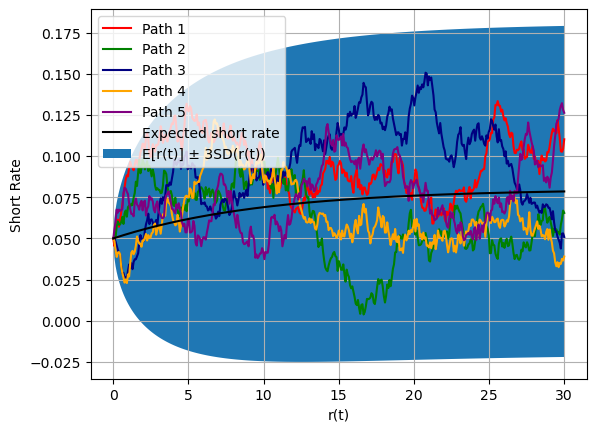

In [26]:
def vasicek_sim_rt_path(a: float, b: float, sigma: float, r0: float, T: float, n: float):
    h = T / n
    r = np.empty(n+1)
    r[0] = r0

    for i in range(1, n + 1):
        r[i] = r[i - 1] + a * (b - r[i - 1]) * h + sigma * np.random.normal() * h**(0.5)

    return r



ts = np.linspace(0, 30, 401)
t = ts

sd = vasicek_rt_var(a, sigma, t) **(0.5)
lower_bound = vasicek_rt_mean(a, b, r0, t) - 3 * sd
upper_bound = vasicek_rt_mean(a, b, r0, t) + 3 * sd


plt.plot(ts, vasicek_sim_rt_path(a, b, sigma, r0, 30, 400), color = "red", label = "Path 1")
plt.plot(ts, vasicek_sim_rt_path(a, b, sigma, r0, 30, 400), color = "green", label = "Path 2")
plt.plot(ts, vasicek_sim_rt_path(a, b, sigma, r0, 30, 400), color = "navy", label = "Path 3")
plt.plot(ts, vasicek_sim_rt_path(a, b, sigma, r0, 30, 400), color = "orange", label = "Path 4")
plt.plot(ts, vasicek_sim_rt_path(a, b, sigma, r0, 30, 400), color = "purple", label = "Path 5")
plt.plot(ts, vasicek_rt_mean(a, b, r0, t), color = "black", label ="Expected short rate")
plt.fill_between(ts, lower_bound, upper_bound, label ="E[r(t)] ± 3SD(r(t))")
plt.xlabel("r(t)")
plt.ylabel("Short Rate")
plt.legend()
plt.grid()
plt.show()


In [13]:
def discretized_vasicek_formula(a, b, r0, sigma, h):
    """
    Vasicek formula for discrete times (simulations)
    """
    random_variable = np.random.normal()
    new_r = r0 + (a*(b - r0) * h) + (sigma * random_variable * np.sqrt(h)) 
    return new_r

In [27]:
def vasicek_sim_rt_path(a, b, sigma, r0, T, n):
    h = T / n
    rn = r0 + (a * (b - r0) * h) + (sigma * np.random.normal() * (h**(0.5)))
    
    rate_path = []
    
    for idx in range(n):
        r0 = rn
        rate_path.append(r0)
    
    return rate_path

In [38]:
def vasicek_payoff_options(a, b, sigma, t, T, rts, n, K, payoff_func):

    h = (T - t) / n
    
    discount_factor = e**(-1 * h * np.sum(rts))

    Z_T0_TB = vasicek_zcb(a, b, sigma, 0, T - t, rts[-1])

    option_T = payoff_func(Z_T0_TB)
    
    return discount_factor * option_T

In [74]:
def vasicek_sim_expected_pv(a, b, sigma, r0, t, T, nsims, n, K, option_type):

    call_payoff = lambda Z : np.maximum(Z - K, 0)
    put_payoff = lambda Z : np.maximum(K - Z, 0)

    if option_type == "call":
        function_payoff = call_payoff
    elif option_type == "put":
        function_payoff = put_payoff
    else:
        raise ValueError("put or call")
    

    paths = []
    for i in range(nsims):        
        path = vasicek_sim_rt_path(a, b, sigma, r0, t, n )[:-1]
        paths.append(path)


    PV = []
    for singular_path in paths:
        pv = vasicek_payoff_options(a, b, sigma, t, T, singular_path, n, K, function_payoff)
        PV.append(pv)
 

    return np.mean(PV)

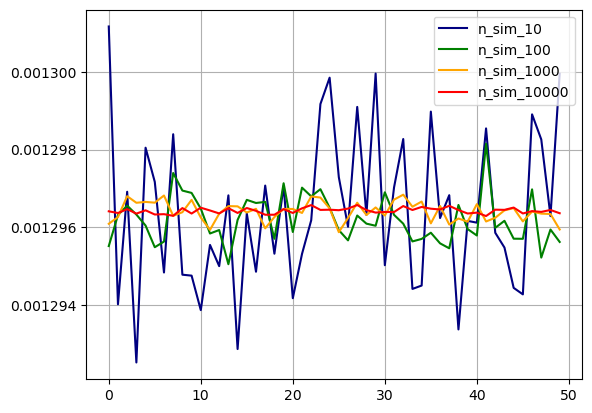

In [80]:
n_simulations = [10, 100, 1000, 10000]
r = 50
n = 30
n_sim_10 = [vasicek_sim_expected_pv(a=a, b=b, sigma=sigma, r0=r0, t=TO, T=TB, nsims=10, n=n, K=K, option_type="put") for _ in range(r)]
n_sim_100 = [vasicek_sim_expected_pv(a=a, b=b, sigma=sigma, r0=r0, t=TO, T=TB, nsims=100, n=n, K=K, option_type="put") for _ in range(r)]
n_sim_1000 = [vasicek_sim_expected_pv(a=a, b=b, sigma=sigma, r0=r0, t=TO, T=TB, nsims=1000, n=n, K=K, option_type="put") for _ in range(r)]
n_sim_10000 = [vasicek_sim_expected_pv(a=a, b=b, sigma=sigma, r0=r0, t=TO, T=TB, nsims=10000, n=n, K=K, option_type="put") for _ in range(r)]

plt.plot(n_sim_10, color="navy", label="n_sim_10")
plt.plot(n_sim_100, color="green", label="n_sim_100")
plt.plot(n_sim_1000, color="orange", label="n_sim_1000")
plt.plot(n_sim_10000, color="red", label="n_sim_10000")
plt.grid()
plt.legend()
plt.show()
